In [67]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

# Simulating carrier noise?

Let's try simulating some carrier noise and see if we can get it to look a bit like what we see in the experiment.

## First: just a sine wave

In [130]:
T = 1000 # we need a long time to get good spectral resolution
N = T * 50 # this will set our nyquist frequency

t = np.linspace(0,T,N,endpoint=False)
v1 = np.cos(2*np.pi*t) # 1 secon period

(0, 5)

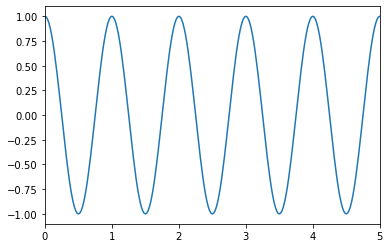

In [131]:
plt.plot(t,v1)
plt.xlim(0,5)

(0.975, 1.025)

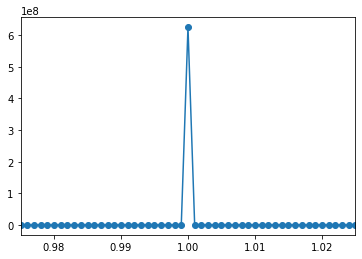

In [132]:
v1t = np.fft.fft(v1)

# For plotting, let's shift them
v1ts = np.fft.fftshift(v1t)
fs = np.fft.fftshift(np.fft.fftfreq(len(v1), d=t[1]))

plt.plot(fs,np.abs(v1ts)**2,"o-")
span = 0.05
plt.xlim(1-span/2,1+span/2)

Of course, the spectral resolution of our FFT depends on the lenth of our time trace.

Actually, very useful to look at a spectrum on a log scale.

(1e-25, 2000000000.0)

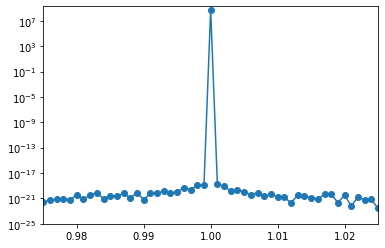

In [136]:
plt.plot(fs,np.abs(v1ts)**2,"o-")
span = 0.05
plt.xlim(1-span/2,1+span/2)
plt.yscale('log')
plt.ylim(1e-25,2e9)

Hmmm...not a perfect delta function! Why? Good question...

## Now: try amplitude noise

In the units above, let's make a amplitude noise spectrum that has a cutoff of 20 mHz. 

The filter function is (OK, now I have to check my own lecture notes...): 

$$
\frac{1}{i\omega/\omega_0 + 1}
$$

In [153]:
amp = np.random.normal(loc=1,scale=1e-2, size=N)

cutoff = 0.02
f = np.fft.fftfreq(N,d=t[1])
amp_t = np.fft.fft(amp)
low_pass = 1/(1j*(f/cutoff)+1)
amp_fil = np.real(np.fft.ifft(amp_t*low_pass))

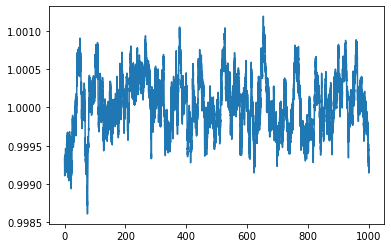

In [154]:
plt.plot(t,amp_fil)

In [155]:
v2 = amp_fil*v1

(-1.03, -0.97)

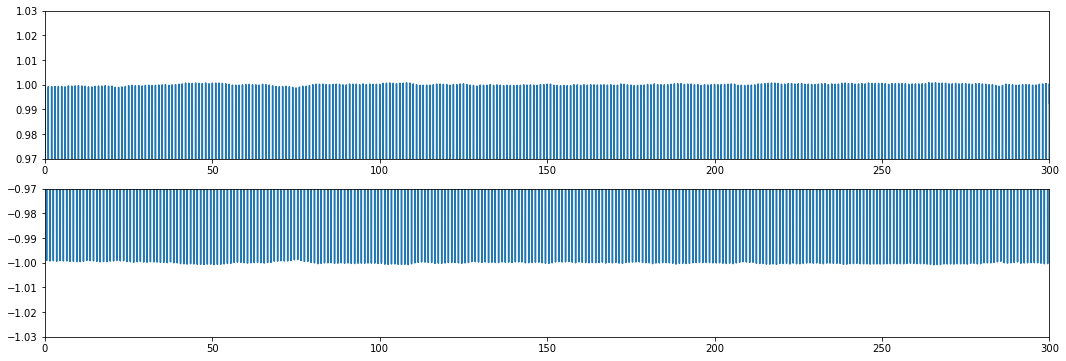

In [156]:
plt.subplots(figsize=(18,6))
plt.subplot(211)
plt.plot(t,v2)
plt.xlim(0,300)
dy = 0.03
plt.ylim(1-dy,1+dy)
plt.subplot(212)
plt.plot(t,v2)
plt.xlim(0,300)
plt.ylim(-1-dy,-1+dy)

Yep, looks like amplitude noise to me :)

Let's check the FFT:

(1e-07, 2000000000.0)

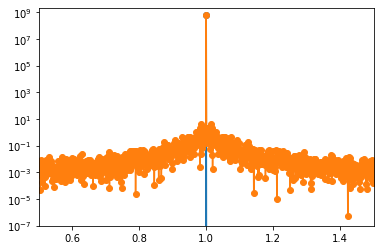

In [157]:
vt2 = np.fft.fft(v2)

# For plotting, let's shift them
vt2s = np.fft.fftshift(vt2)
fs = np.fft.fftshift(np.fft.fftfreq(len(v1), d=t[1]))

plt.plot(fs,np.abs(v1ts)**2,"o-")
plt.plot(fs,np.abs(vt2s)**2,"o-")
span = 1
plt.xlim(1-span/2,1+span/2)
plt.yscale('log')
plt.ylim(1e-7,2e9)

OK, it looks noisy. But do I see the cutoff somewhere? Should I see the cutoff somewhere?

## Sanity check: Amplitude modulation

Modulate the amplitude sinusoidally. This should give sidebands. Right?

In [158]:
v3 = (1+0.1*np.sin(2*np.pi*t*0.02))*v1

(0, 100)

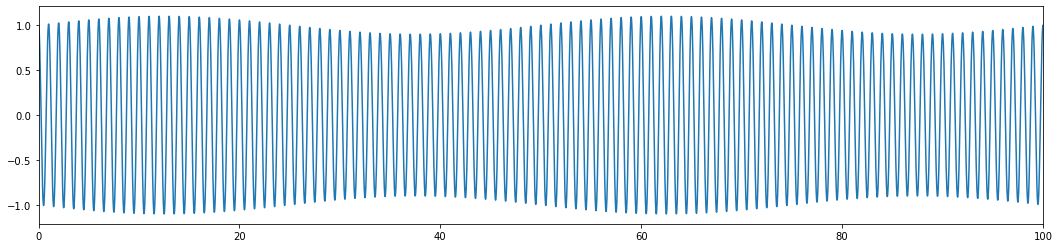

In [159]:
plt.subplots(figsize=(18,4))
plt.plot(t,v3)
plt.xlim(0,100)

In [164]:
def plot_spec(vp):
    vpt = np.fft.fft(vp)
    
    # For plotting, let's shift them
    vpts = np.fft.fftshift(vpt)
    fs = np.fft.fftshift(np.fft.fftfreq(len(v1), d=t[1]))

    plt.plot(fs,np.abs(v1ts)**2,"o-")
    plt.plot(fs,np.abs(vpts)**2,"o-")
    span = 0.1
    plt.xlim(1-span/2,1+span/2)
    plt.yscale('log')
    plt.ylim(1e-25,2e9)

In [165]:
plot_spec(v3)

OK, this works. Good, I'm not going completely insane! :)

But it raises the question: how do I get a "noise shoulder"? 

I think I need to take *many* realisations of the noise and then average together the resulting power spectra. This is a bit what is done in power spectrum estimation techniques like `scipy.welch`:

https://en.wikipedia.org/wiki/Spectral_density_estimation

Probably running it for 100 times longe time trace then using `scipy.welch` properly would give a good spectral estimation. For another night

## Phase modulation

Let's try phase modulation: 

$$
\cos(\omega t + \cos(\omega_m t))
$$


In [166]:
phase = np.cos(2*np.pi*0.02*t)*5e-2
v4 = np.cos(2*np.pi*t + phase)

In [167]:
off=0
plt.subplots(figsize=(18,8))
plt.subplot(211)
plt.plot(t,v1)
plt.plot(t,v4)
plt.xlim(off,off+20)
plt.subplot(212)
plt.plot(t,v4-v1)
plt.xlim(off,off+20)

(0, 20)

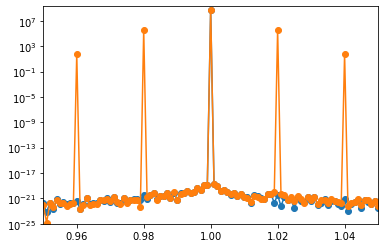

In [168]:
plot_spec(v4)

Yep, this works. Interesting, you  can also see the second sidebands a bit. I do find that the second left one is a dip a bit strange. 